In [1]:
from train import *
from model import *
from helpers import *
from include import *

import os
import plac
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import clear_output

import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    dtype = torch.FloatTensor

In [2]:
# low shots
num_of_low_shots = 8
num_of_val = 24
image_size = 128

# Root directory for dataset
data_root = "./CelebA_data/celeba"

batch_size = 2
data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor() ]))
# validate images
val_set = IndexedDataset(torch.utils.data.Subset(data_set, range(24, 44, 1)))
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

In [3]:
val_image, _, _ = val_set[1]
img_clean_var = val_image.view(-1, 3, image_size, image_size).to(device)

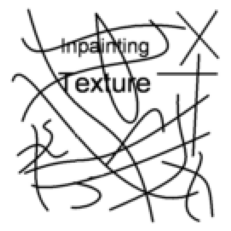

In [4]:
# given mask
output_depth = 3
img_mask_pil = Image.open('./mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * output_depth)
mask_var = np_to_var(mask_np).type(dtype)
plt.imshow(var_to_np(mask_var).transpose(1, 2, 0))
plt.axis('off');

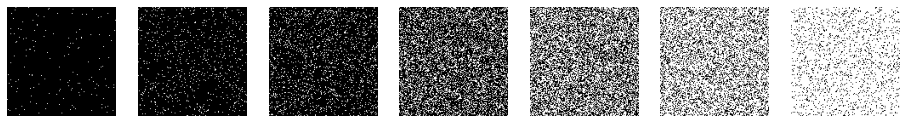

In [5]:
# random masks
ratios = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
masks = torch.zeros(len(ratios), 3, image_size, image_size).to(device)

plt.figure(figsize=(16, 8))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    tmp = torch.cuda.FloatTensor(1, 1, image_size, image_size).uniform_() < ratios[i]
    tmp = tmp.view(-1, 1, 128, 128)
    
    mask_np = var_to_np(tmp)
    mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * 3)
    masks[i] = np_to_var(mask_np).type(dtype)

    plt.imshow(mask_np.transpose(1, 2, 0))
    plt.axis('off');

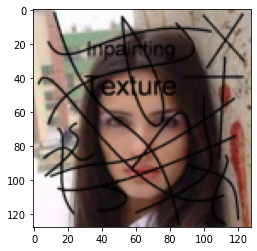

In [6]:
img_noisy_var = img_clean_var * mask_var
img_noisy_np = var_to_np(img_noisy_var)

# img_clean_var = val_image.view(1, 3, image_size, image_size).to(device)
# img_noisy_var = Variable(img_clean_var).to(device) * mask_var
imgshow(img_noisy_var)

(-0.5, 127.5, 127.5, -0.5)

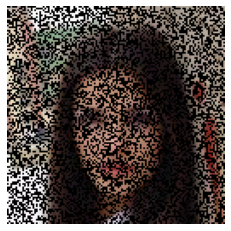

In [7]:
mask_var = masks[4].to(device)
img_noisy_var = img_clean_var * mask_var
img_noisy_np = var_to_np(img_noisy_var)

# img_clean_var = val_image.view(1, 3, image_size, image_size).to(device)
# img_noisy_var = Variable(img_clean_var).to(device) * mask_var
imgshow(img_noisy_var)
plt.axis('off')

In [8]:
# # # model 1
num_channels = [128]*3
net = fixed_decodernw(num_channels_up=num_channels).type(dtype)

print("number of parameters: ", num_param(net))
print(net)
rnd = 500
numit = 10000
rn = 0.005

# model 3
# num_channels = [32]*3
# net = fixed_decodernw(num_channels_up=num_channels, upsample_mode='none').type(dtype)

# print("number of parameters: ", num_param(net))
# print(net)
# rnd = 500
# numit = 8000
# rn = 0.005

number of parameters:  1115520
Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((1, 0, 1, 0))
    (1): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (2): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (3): Upsample(scale_factor=2.0, mode=bilinear)
  (4): ReLU()
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Sequential(
    (0): ReflectionPad2d((1, 0, 1, 0))
    (1): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (7): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (8): Upsample(scale_factor=2.0, mode=bilinear)
  (9): ReLU()
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Sequential(
    (0): ReflectionPad2d((1, 0, 1, 0))
    (1): Conv2d(128, 12

In [9]:
mse_n, mse_t, ni, net = new_fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0015,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        upsample_mode="bilinear" # "none" for model 3
                        )

input shape:  [1, 128, 16, 16]
optimize with adam 0.0015


(-0.5, 127.5, 127.5, -0.5)

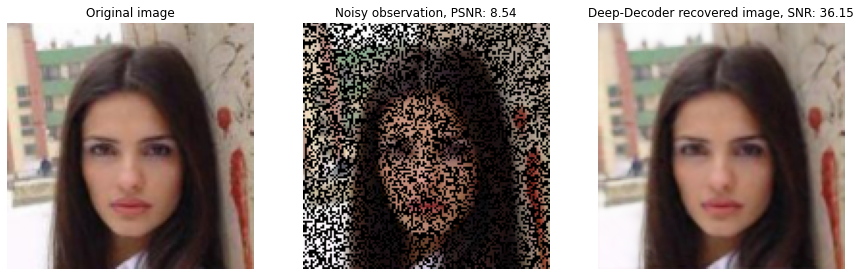

In [10]:
def myimgshow(plt,img):
    plt.imshow(np.clip((img).cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')

In [11]:
# model 2
num_channels = [64]*3
net = deconv_decoder(3, num_channels_up=num_channels, filter_size=4, padding=[9, 17, 33, 65]).type(dtype)

print("number of parameters: ", num_param(net))
print(net)
rnd = 500
numit = 10000
rn = 0.005

number of parameters:  262848
Sequential(
  (1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(9, 9), bias=False)
  (2): Upsample(scale_factor=2.0, mode=bilinear)
  (3): ReLU()
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(17, 17), bias=False)
  (6): Upsample(scale_factor=2.0, mode=bilinear)
  (7): ReLU()
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(33, 33), bias=False)
  (10): Upsample(scale_factor=2.0, mode=bilinear)
  (11): ReLU()
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(65, 65), bias=False)
  (14): ReLU()
  (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Sequential(

In [12]:
mse_n, mse_t, ni, net = new_fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0015,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        upsample_mode='bilinear'
                        )

input shape:  [1, 64, 16, 16]
optimize with adam 0.0015


(-0.5, 127.5, 127.5, -0.5)

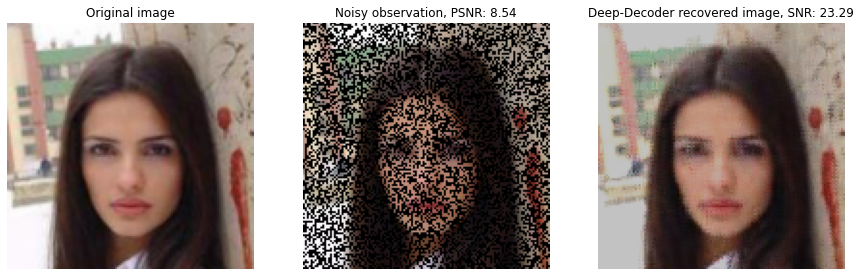

In [13]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')

In [14]:
# model 4
num_channels = [64]*3
net = deconv_decoder(3, num_channels_up=num_channels, upsample_mode='none', filter_size=4, padding=[65]*4).type(dtype)

print("number of parameters: ", num_param(net))
print(net)
rnd = 500
numit = 10000
rn = 0.005

number of parameters:  262848
Sequential(
  (1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(65, 65), bias=False)
  (2): ReLU()
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(65, 65), bias=False)
  (5): ReLU()
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(65, 65), bias=False)
  (8): ReLU()
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(65, 65), bias=False)
  (11): ReLU()
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (14): Sigmoid()
  (15): Tanh()
)

In [15]:
mse_n, mse_t, ni, net = new_fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0015,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        upsample_mode='none'
                        )

input shape:  [1, 64, 128, 128]
optimize with adam 0.0015


(-0.5, 127.5, 127.5, -0.5)

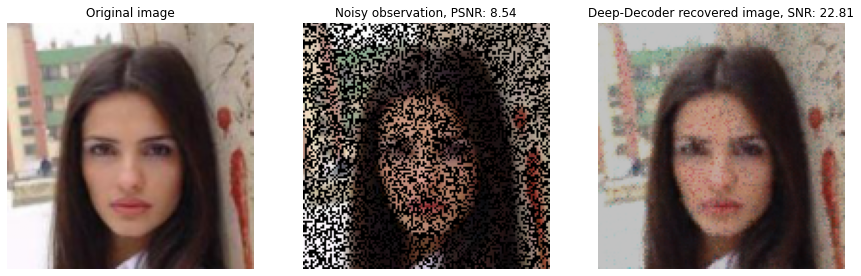

In [16]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')

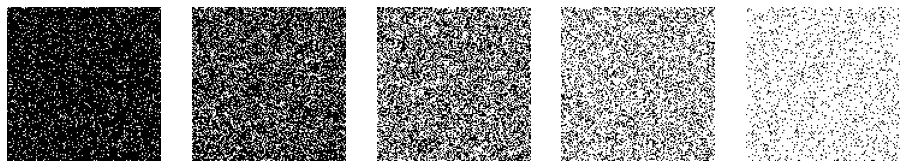

In [17]:
# random masks
ratios = np.arange(0.1, 1.1, 0.2)
masks_var = torch.zeros(len(ratios), 3, image_size, image_size).to(device)

plt.figure(figsize=(16, 8))
for i in range(len(masks_var)):
    plt.subplot(1, len(masks_var), i + 1)
    tmp = torch.cuda.FloatTensor(1, 1, image_size, image_size).uniform_() < ratios[i]
    tmp = tmp.view(-1, 1, 128, 128)
    
    mask_np = var_to_np(tmp)
    mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * 3)
    masks_var[i] = np_to_var(mask_np).type(dtype)

    plt.imshow(mask_np.transpose(1, 2, 0))
    plt.axis('off');

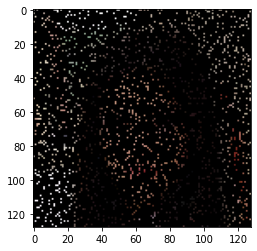

In [18]:
img_noisy_var = img_clean_var * masks_var[0]
img_noisy_np = var_to_np(img_noisy_var)

imgshow(img_noisy_var)

In [8]:
num_channels = [128]*3
net = decodernw(num_channels_up=num_channels, upsample_first = True).type(dtype)

print("number of parameters: ", num_param(net))
print(net)
rnd = 500
numit = 1000
rn = 0.005

number of parameters:  66944
Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (2): Upsample(scale_factor=2.0, mode=bilinear)
  (3): ReLU()
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (6): Upsample(scale_factor=2.0, mode=bilinear)
  (7): ReLU()
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (10): Upsample(scale_factor=2.0, mode=bilinear)
  (11): ReLU()
  (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(128, 128, kernel_size=(

In [9]:
mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0025,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        )

shape:  [1, 128, 16, 16]
optimize with adam 0.0025


(-0.5, 127.5, 127.5, -0.5)

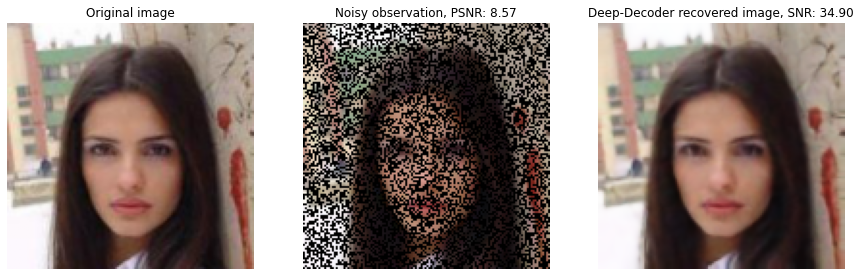

In [10]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var.detach()) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')